In [56]:
# importing modules

import numpy as np
import tensorflow as tf
import keras
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras import Sequential
from keras.layers import (InputLayer, Conv2D, MaxPooling2D, MaxPool2D, GlobalAveragePooling2D, 
                          Dense, BatchNormalization, Dropout, ELU, UpSampling2D)
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Nadam
from keras.layers import Input, Multiply, UpSampling2D
from keras.models import Model
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

In [57]:
import tensorflow as tf
import numpy as np

# Paths (both PNG and JPG/JPEG images)
ai_png_path = r"E:\AI Generated vs Real Image Classifier Using Deep Learning\AiArtData\AiArtData\*.png"
ai_jpg_path = r"E:\AI Generated vs Real Image Classifier Using Deep Learning\AiArtData\AiArtData\*.jpg"
ai_jpeg_path = r"E:\AI Generated vs Real Image Classifier Using Deep Learning\AiArtData\AiArtData\*.jpeg"

real_png_path = r"E:\AI Generated vs Real Image Classifier Using Deep Learning\RealArt\RealArt\*.png"
real_jpg_path = r"E:\AI Generated vs Real Image Classifier Using Deep Learning\RealArt\RealArt\*.jpg"
real_jpeg_path = r"E:\AI Generated vs Real Image Classifier Using Deep Learning\RealArt\RealArt\*.jpeg"

# Create datasets from file paths
ai_files = (
    tf.data.Dataset.list_files(ai_png_path, shuffle=True)
    .concatenate(tf.data.Dataset.list_files(ai_jpg_path, shuffle=True))
    .concatenate(tf.data.Dataset.list_files(ai_jpeg_path, shuffle=True))
)

real_files = (
    tf.data.Dataset.list_files(real_png_path, shuffle=True)
    .concatenate(tf.data.Dataset.list_files(real_jpg_path, shuffle=True))
    .concatenate(tf.data.Dataset.list_files(real_jpeg_path, shuffle=True))
)

# Function to load and preprocess images (works for PNG & JPG)
def load_and_preprocess(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_image(img, channels=3, expand_animations=False)  # auto-detect format
    img = tf.image.resize(img, [224, 224])
    img = tf.cast(img, tf.float32) / 255.0   # Normalize [0,1]
    return img, label

# Apply preprocessing and labels
ai_dataset = ai_files.map(lambda x: load_and_preprocess(x, 1))   # Label = 1 (AI)
real_dataset = real_files.map(lambda x: load_and_preprocess(x, 0))  # Label = 0 (Real)

# Combine datasets
combined_dataset = ai_dataset.concatenate(real_dataset)

# Shuffle & batch
combined_dataset = combined_dataset.shuffle(2000).batch(32)

# Convert to numpy arrays
images_list, labels_list = [], []
for images, labels in combined_dataset:
    images_list.extend(images.numpy())
    labels_list.extend(labels.numpy())

images_array = np.array(images_list)
labels_array = np.array(labels_list)

print("✅ Dataset loaded successfully!")
print("Images shape:", images_array.shape)
print("Labels shape:", labels_array.shape)


✅ Dataset loaded successfully!
Images shape: (970, 224, 224, 3)
Labels shape: (970,)


In [58]:
# Splitting the data into training, testing, and validation sets
x_train, x_temp, y_train, y_temp = train_test_split(images_array, labels_array, test_size=0.3,random_state=42)
x_test, x_val, y_test, y_val = train_test_split(x_temp, y_temp, test_size=0.5,random_state=42)

# Printing the shapes of split data
print("x_train:", x_train.shape)
print("y_train:", y_train.shape)
print("x_test:", x_test.shape)
print("y_test:", y_test.shape)
print("x_val:", x_val.shape)
print("y_val:", y_val.shape)

x_train: (679, 224, 224, 3)
y_train: (679,)
x_test: (145, 224, 224, 3)
y_test: (145,)
x_val: (146, 224, 224, 3)
y_val: (146,)


### CNN

In [49]:
from keras.regularizers import l1_l2

model = Sequential() # sequential model

model.add(InputLayer(shape=(224, 224, 3)))

model.add(Conv2D(filters=32, kernel_size=3, activation=ELU(), padding="same")) # convolution block with downsampling and batch normalization
model.add(MaxPool2D())

model.add(Conv2D(filters=64, kernel_size=3, activation=ELU(), padding="same")) # convolution block with downsampling and batch normalization
model.add(MaxPool2D())

model.add(Conv2D(filters=128, kernel_size=3, activation=ELU(), padding="same")) # convolution block with downsampling and batch normalization
model.add(MaxPool2D())

model.add(Conv2D(filters=256, kernel_size=3, activation=ELU(), padding="same")) # convolution block with downsampling and batch normalization
model.add(MaxPool2D())

model.add(GlobalAveragePooling2D())

model.add(Dense(1024, activation=ELU())) # dense layer
model.add(Dense(512, activation=ELU())) # dense layer
model.add(Dense(256, activation=ELU())) # dense layer
model.add(Dense(128, activation=ELU())) # dense layer

model.add(Dense(1, activation='sigmoid'))

# callbacks: model checkpoint and reducing lr on plateau for focusing model towards problem
model_checkpoint = ModelCheckpoint('model.keras', monitor='val_accuracy', save_best_only=True, verbose=1, mode='max')

model.compile(optimizer=Nadam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy']) # compiling model layers

model.summary() # model summary

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_309 (Conv2D)             │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_310 (Conv2D)             │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_311 (Conv2D)             │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_312 (Conv2D)             │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_8      │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 1024)           │       263,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,340,737 (5.11 MB)

 Trainable params: 1,340,737 (5.11 MB)

 Non-trainable params: 0 (0.00 B)

In [50]:
# Training model
history = model.fit(x_train,y_train,batch_size=32,epochs=40,verbose=1,validation_data=(x_val,y_val),callbacks=[model_checkpoint])

Epoch 1/40
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.5455 - loss: 0.6873
Epoch 1: val_accuracy improved from None to 0.54795, saving model to model.keras
22/22 ━━━━━━━━━━━━━━━━━━━━ 70s 3s/step - accuracy: 0.5596 - loss: 0.6846 - val_accuracy: 0.5479 - val_loss: 0.6879
Epoch 2/40
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6010 - loss: 0.6554
Epoch 2: val_accuracy did not improve from 0.54795
22/22 ━━━━━━━━━━━━━━━━━━━━ 55s 3s/step - accuracy: 0.6009 - loss: 0.6603 - val_accuracy: 0.5342 - val_loss: 0.6877
Epoch 3/40
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5915 - loss: 0.6618
Epoch 3: val_accuracy improved from 0.54795 to 0.64384, saving model to model.keras
22/22 ━━━━━━━━━━━━━━━━━━━━ 55s 3s/step - accuracy: 0.6303 - loss: 0.6405 - val_accuracy: 0.6438 - val_loss: 0.6560
Epoch 4/40
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6323 - loss: 0.6450
Epoch 4: val_accuracy did not improve from 0.64384
22/22 ━━━━━━━━━━━━━━━━━━━━ 57s 3s/step - accuracy: 0.636

In [51]:
# testing model 

model2 = keras.models.load_model('model.keras', custom_objects={"ELU": keras.layers.ELU,"PReLU": keras.layers.PReLU}) # loading saved model

y_pred = model2.predict(x_test) # predicting

y_pred = (y_pred > 0.5).astype(int) # turning to class labels

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Precision
precision = precision_score(y_test, y_pred)
print("Precision:", precision)

# Recall
recall = recall_score(y_test, y_pred)
print("Recall:", recall)

# F1 Score
f1 = f1_score(y_test, y_pred)
print("F1 Score:", f1)

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 562ms/step
Accuracy: 0.6413793103448275
Precision: 0.611764705882353
Recall: 0.7323943661971831
F1 Score: 0.6666666666666666
Confusion Matrix:
[[41 33]
 [19 52]]


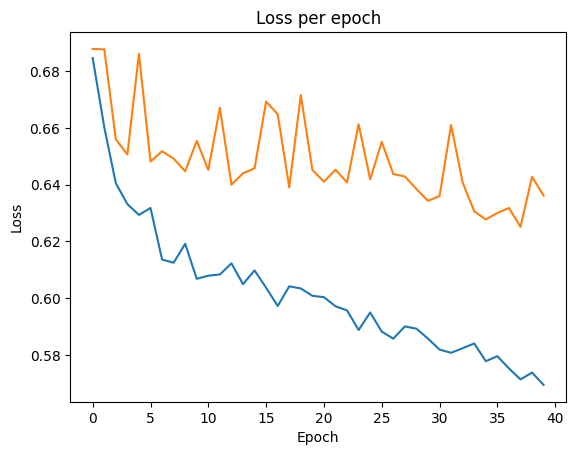

In [52]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss per epoch")
plt.show()

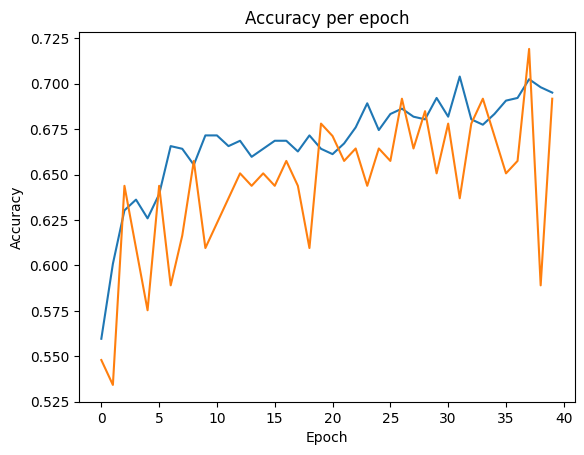

In [53]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy per epoch")
plt.show()

### VGG16

In [54]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model

# Load the VGG16 model and create the feature extractor
vgg16_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
feature_extractor = Model(inputs=vgg16_model.input, outputs=vgg16_model.get_layer('block5_pool').output)

# Freeze the convolutional base layers
for layer in feature_extractor.layers:
    layer.trainable = False

# Add custom dense layers on top
x = feature_extractor.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
output = Dense(1, activation='sigmoid')(x)

# Create the final model
model = Model(inputs=feature_extractor.input, outputs=output)

model_checkpoint = ModelCheckpoint('model.keras', monitor='val_accuracy', save_best_only=True, verbose=1, mode='max')
reduce_lr = ReduceLROnPlateau(mode='min', monitor='val_loss', factor=0.1, patience=5, min_lr=0.00000001, verbose=1)

model.summary()

Model: "functional_97"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_9      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 1)              │         1,025 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,241,025 (58.14 MB)

 Trainable params: 526,337 (2.01 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [55]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=20, batch_size=32,callbacks=[reduce_lr,model_checkpoint])

Epoch 1/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.6206 - loss: 0.6622 
Epoch 1: val_accuracy improved from None to 0.64384, saving model to model.keras
22/22 ━━━━━━━━━━━━━━━━━━━━ 286s 13s/step - accuracy: 0.6583 - loss: 0.6266 - val_accuracy: 0.6438 - val_loss: 0.6334 - learning_rate: 0.0010
Epoch 2/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.7382 - loss: 0.5484 
Epoch 2: val_accuracy improved from 0.64384 to 0.75342, saving model to model.keras
22/22 ━━━━━━━━━━━━━━━━━━━━ 282s 13s/step - accuracy: 0.7290 - loss: 0.5310 - val_accuracy: 0.7534 - val_loss: 0.5362 - learning_rate: 0.0010
Epoch 3/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.7553 - loss: 0.5062 
Epoch 3: val_accuracy did not improve from 0.75342
22/22 ━━━━━━━━━━━━━━━━━━━━ 280s 13s/step - accuracy: 0.7688 - loss: 0.4959 - val_accuracy: 0.7466 - val_loss: 0.5148 - learning_rate: 0.0010
Epoch 4/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.7994 - loss: 0.4455 
Epoch 4: val_accuracy

KeyboardInterrupt: 

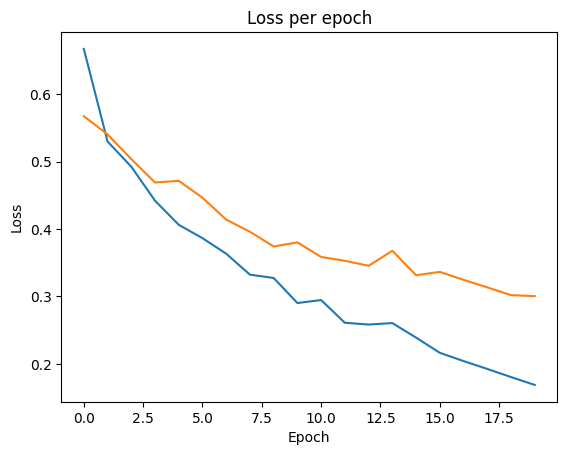

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss per epoch")
plt.show()

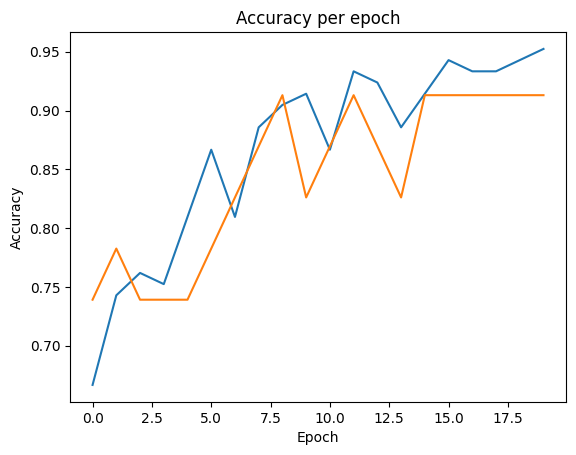

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy per epoch")
plt.show()

### Xception

In [ ]:
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model

# Load the Xception model and create the feature extractor
xception_model = Xception(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
feature_extractor = Model(inputs=xception_model.input, outputs=xception_model.get_layer('block14_sepconv2_act').output)

# Freeze the convolutional base layers
for layer in feature_extractor.layers:
    layer.trainable = False

# Add custom dense layers on top
x = feature_extractor.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)

output = Dense(1, activation='sigmoid')(x)

# Create the final model
model = Model(inputs=feature_extractor.input, outputs=output)

model_checkpoint = ModelCheckpoint('att_model.keras', monitor='val_accuracy', save_best_only=True, verbose=1, mode='max')
reduce_lr = ReduceLROnPlateau(mode='min', monitor='val_loss', factor=0.1, patience=5, min_lr=0.00000001, verbose=1)

# Print the model summary
model.summary()

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 7s 0us/step


Model: "functional_61"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 111, 111,  │        864 │ input_layer_4[0]… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_bn     │ (None, 111, 111,  │        128 │ block1_conv1[0][… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_act    │ (None, 111, 111,  │          0 │ block1_conv1_bn[… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 109, 109,  │     18,432 │ block1_conv1_act… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_bn     │ (None, 109, 109,  │        256 │ block1_conv2[0][… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_act    │ (None, 109, 109,  │          0 │ block1_conv2_bn[… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1     │ (None, 109, 109,  │      8,768 │ block1_conv2_act… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1_bn  │ (None, 109, 109,  │        512 │ block2_sepconv1[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_act │ (None, 109, 109,  │          0 │ block2_sepconv1_… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2     │ (None, 109, 109,  │     17,536 │ block2_sepconv2_… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_bn  │ (None, 109, 109,  │        512 │ block2_sepconv2[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 55, 55,    │      8,192 │ block1_conv2_act… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 55, 55,    │          0 │ block2_sepconv2_… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 55, 55,    │        512 │ conv2d_8[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 55, 55,    │          0 │ block2_pool[0][0… │
│                     │ 128)              │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_sepconv1_act │ (None, 55, 55,    │          0 │ add[0][0]       

 Total params: 22,960,681 (87.59 MB)

 Trainable params: 2,099,201 (8.01 MB)

 Non-trainable params: 20,861,480 (79.58 MB)

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=20, batch_size=32,callbacks=[reduce_lr,model_checkpoint])

Epoch 1/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7302 - loss: 0.9645
Epoch 1: val_accuracy improved from None to 0.73913, saving model to att_model.keras
4/4 ━━━━━━━━━━━━━━━━━━━━ 26s 6s/step - accuracy: 0.7333 - loss: 1.0612 - val_accuracy: 0.7391 - val_loss: 0.6650 - learning_rate: 0.0010
Epoch 2/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7111 - loss: 0.5718
Epoch 2: val_accuracy did not improve from 0.73913
4/4 ━━━━━━━━━━━━━━━━━━━━ 18s 4s/step - accuracy: 0.7143 - loss: 0.5759 - val_accuracy: 0.6957 - val_loss: 0.6113 - learning_rate: 0.0010
Epoch 3/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8940 - loss: 0.2520
Epoch 3: val_accuracy did not improve from 0.73913
4/4 ━━━━━━━━━━━━━━━━━━━━ 18s 5s/step - accuracy: 0.8571 - loss: 0.2785 - val_accuracy: 0.7391 - val_loss: 0.8941 - learning_rate: 0.0010
Epoch 4/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8532 - loss: 0.2507
Epoch 4: val_accuracy did not improve from 0.73913
4/4 ━━━━━━━━━━━━━━━━━━━━ 17

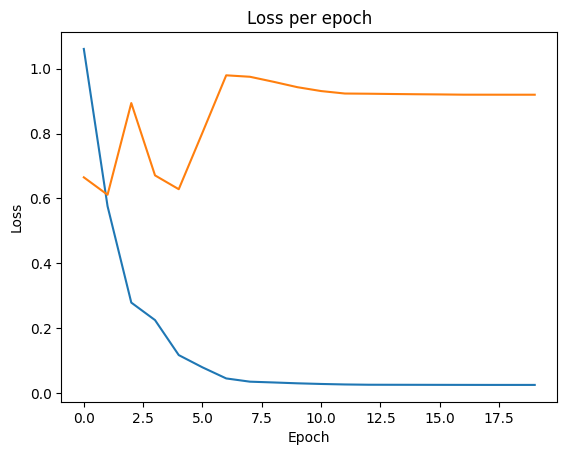

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss per epoch")
plt.show()

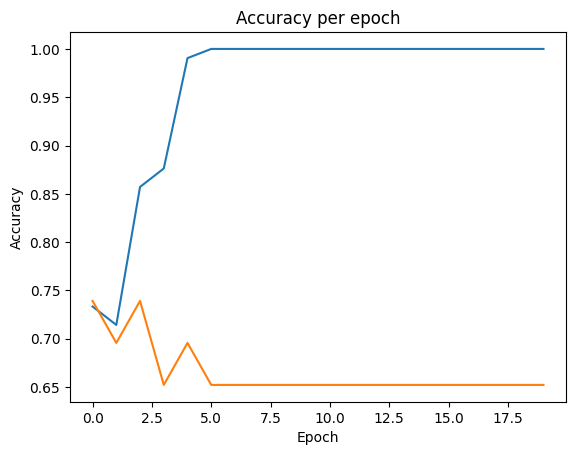

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy per epoch")
plt.show()

### DenseNet121

In [ ]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model

# Load the DenseNet121 model and create the feature extractor
densenet_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
feature_extractor = Model(inputs=densenet_model.input, outputs=densenet_model.get_layer('relu').output)

# Freeze the convolutional base layers
for layer in feature_extractor.layers:
    layer.trainable = False

# Add custom dense layers on top
x = feature_extractor.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)

output = Dense(1, activation='sigmoid')(x)

# Create the final model
model = Model(inputs=feature_extractor.input, outputs=output)

model_checkpoint = ModelCheckpoint('att_model.keras', monitor='val_accuracy', save_best_only=True, verbose=1, mode='max')
reduce_lr = ReduceLROnPlateau(mode='min', monitor='val_loss', factor=0.1, patience=5, min_lr=0.00000001, verbose=1)

# Print the model summary
model.summary()

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Model: "functional_63"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 230, 230,  │          0 │ input_layer_5[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 8,088,129 (30.85 MB)

 Trainable params: 1,050,625 (4.01 MB)

 Non-trainable params: 7,037,504 (26.85 MB)

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=20, batch_size=32,callbacks=[reduce_lr,model_checkpoint])

Epoch 1/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5180 - loss: 1.5401
Epoch 1: val_accuracy improved from None to 0.73913, saving model to att_model.keras
4/4 ━━━━━━━━━━━━━━━━━━━━ 36s 6s/step - accuracy: 0.6190 - loss: 1.7612 - val_accuracy: 0.7391 - val_loss: 1.6453 - learning_rate: 0.0010
Epoch 2/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7762 - loss: 0.8846
Epoch 2: val_accuracy did not improve from 0.73913
4/4 ━━━━━━━━━━━━━━━━━━━━ 12s 3s/step - accuracy: 0.7714 - loss: 0.7436 - val_accuracy: 0.3478 - val_loss: 0.8214 - learning_rate: 0.0010
Epoch 3/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.5362 - loss: 0.8202
Epoch 3: val_accuracy did not improve from 0.73913
4/4 ━━━━━━━━━━━━━━━━━━━━ 15s 4s/step - accuracy: 0.6762 - loss: 0.6323 - val_accuracy: 0.7391 - val_loss: 0.7358 - learning_rate: 0.0010
Epoch 4/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7892 - loss: 0.4326
Epoch 4: val_accuracy did not improve from 0.73913
4/4 ━━━━━━━━━━━━━━━━━━━━ 14

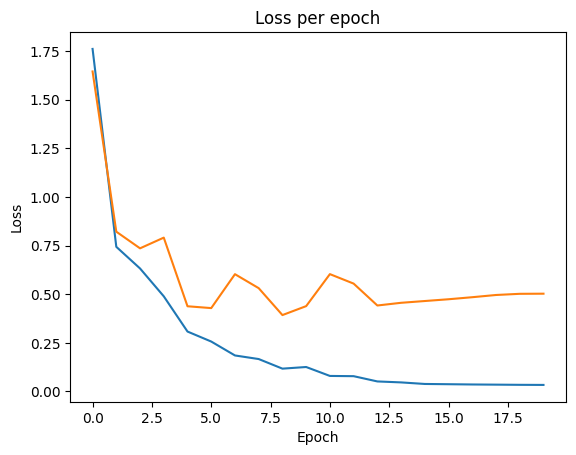

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss per epoch")
plt.show()

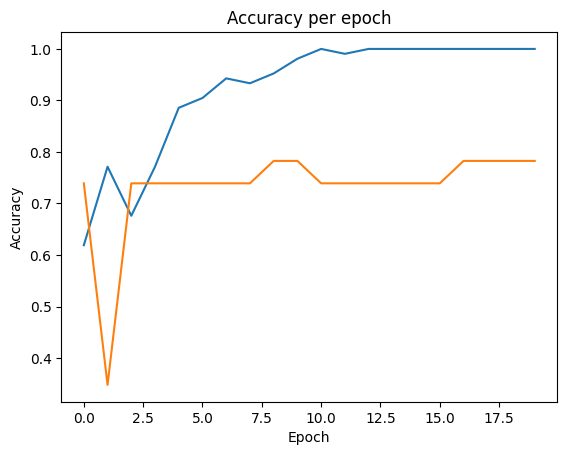

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy per epoch")
plt.show()

### Inception

In [ ]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model

# Load the InceptionV3 model and create the feature extractor
inception_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
feature_extractor = Model(inputs=inception_model.input, outputs=inception_model.get_layer('mixed10').output)

# Freeze the convolutional base layers
for layer in feature_extractor.layers:
    layer.trainable = False

# Add custom dense layers on top
x = feature_extractor.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
output = Dense(1, activation='sigmoid')(x)

# Create the final model
model = Model(inputs=feature_extractor.input, outputs=output)

# Print the model summary
model.summary()

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 8s 0us/step


Model: "functional_65"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_12 (Conv2D)  │ (None, 111, 111,  │        864 │ input_layer_6[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 111, 111,  │         96 │ conv2d_12[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 111, 111,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_13 (Conv2D)  │ (None, 109, 109,  │      9,216 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 109, 109,  │         96 │ conv2d_13[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 109, 109,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_14 (Conv2D)  │ (None, 109, 109,  │     18,432 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 109, 109,  │        192 │ conv2d_14[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 109, 109,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_8     │ (None, 54, 54,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_15 (Conv2D)  │ (None, 54, 54,    │      5,120 │ max_pooling2d_8[… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 54, 54,    │        240 │ conv2d_15[0][0]   │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 54, 54,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_16 (Conv2D)  │ (None, 52, 52,    │    138,240 │ activation_3[0][… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 52, 52,    │        576 │ conv2d_16[0][0]   │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 52, 52,    │          0 │ batch_normalizat

 Total params: 23,901,985 (91.18 MB)

 Trainable params: 2,099,201 (8.01 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=20, batch_size=32,callbacks=[reduce_lr,model_checkpoint])

Epoch 1/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5384 - loss: 2.4877
Epoch 1: val_accuracy did not improve from 0.78261
4/4 ━━━━━━━━━━━━━━━━━━━━ 20s 3s/step - accuracy: 0.6381 - loss: 3.1449 - val_accuracy: 0.7391 - val_loss: 2.3737 - learning_rate: 0.0010
Epoch 2/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6103 - loss: 1.6848
Epoch 2: val_accuracy did not improve from 0.78261
4/4 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.5143 - loss: 1.4641 - val_accuracy: 0.3043 - val_loss: 0.9085 - learning_rate: 0.0010
Epoch 3/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5924 - loss: 0.5801
Epoch 3: val_accuracy did not improve from 0.78261
4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.6667 - loss: 0.5162 - val_accuracy: 0.7391 - val_loss: 0.9971 - learning_rate: 0.0010
Epoch 4/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7131 - loss: 0.7610
Epoch 4: val_accuracy did not improve from 0.78261
4/4 ━━━━━━━━━━━━━━━━━━━━ 10s 3s/step - accuracy: 0.7429 - loss

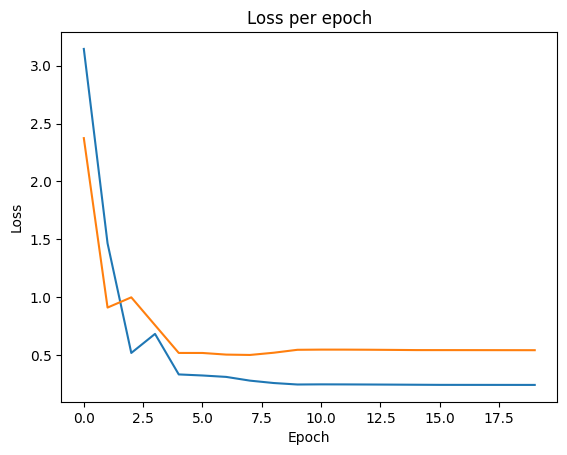

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss per epoch")
plt.show()

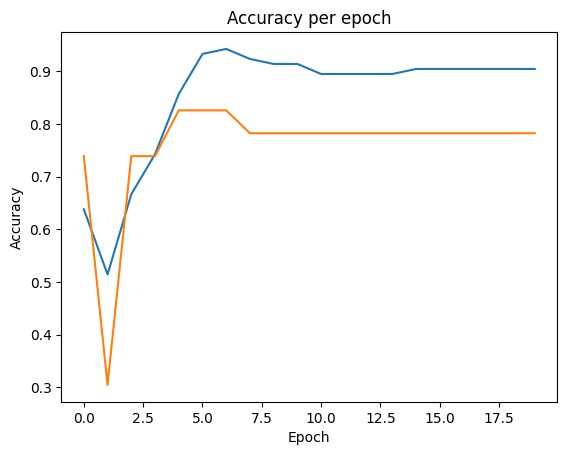

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy per epoch")
plt.show()

### Inception-ResNet-V2

In [59]:
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model

# Load the InceptionResNetV2 model and create the feature extractor
inception_resnet_model = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
feature_extractor = Model(inputs=inception_resnet_model.input, outputs=inception_resnet_model.get_layer('conv_7b_ac').output)

# Freeze the convolutional base layers
for layer in feature_extractor.layers:
    layer.trainable = False

# Add custom dense layers on top
x = feature_extractor.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)

output = Dense(1, activation='sigmoid')(x)

# Create the final model
model = Model(inputs=feature_extractor.input, outputs=output)

model_checkpoint = ModelCheckpoint('att_model.keras', monitor='val_accuracy', save_best_only=True, verbose=1, mode='max')
reduce_lr = ReduceLROnPlateau(mode='min', monitor='val_loss', factor=0.1, patience=5, min_lr=0.00000001, verbose=1)

# Print the model summary
model.summary()

Model: "functional_99"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_10      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_313 (Conv2D) │ (None, 111, 111,  │        864 │ input_layer_10[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 111, 111,  │         96 │ conv2d_313[0][0]  │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_297      │ (None, 111, 111,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_314 (Conv2D) │ (None, 109, 109,  │      9,216 │ activation_297[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 109, 109,  │         96 │ conv2d_314[0][0]  │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_298      │ (None, 109, 109,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_315 (Conv2D) │ (None, 109, 109,  │     18,432 │ activation_298[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 109, 109,  │        192 │ conv2d_315[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_299      │ (None, 109, 109,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_20    │ (None, 54, 54,    │          0 │ activation_299[0… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_316 (Conv2D) │ (None, 54, 54,    │      5,120 │ max_pooling2d_20… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 54, 54,    │        240 │ conv2d_316[0][0]  │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_300      │ (None, 54, 54,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_317 (Conv2D) │ (None, 52, 52,    │    138,240 │ activation_300[0… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 52, 52,    │        576 │ conv2d_317[0][0]  │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_301      │ (None, 52, 52,    │          0 │ batch_normalizat

 Total params: 55,911,649 (213.29 MB)

 Trainable params: 1,574,913 (6.01 MB)

 Non-trainable params: 54,336,736 (207.28 MB)

In [60]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=20, batch_size=32,callbacks=[reduce_lr,model_checkpoint])

Epoch 1/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.5301 - loss: 1.9205
Epoch 1: val_accuracy improved from None to 0.50685, saving model to att_model.keras
22/22 ━━━━━━━━━━━━━━━━━━━━ 182s 8s/step - accuracy: 0.5979 - loss: 1.2008 - val_accuracy: 0.5068 - val_loss: 0.9444 - learning_rate: 0.0010
Epoch 2/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.7597 - loss: 0.5227
Epoch 2: val_accuracy improved from 0.50685 to 0.76027, saving model to att_model.keras
22/22 ━━━━━━━━━━━━━━━━━━━━ 151s 7s/step - accuracy: 0.7703 - loss: 0.4828 - val_accuracy: 0.7603 - val_loss: 0.5667 - learning_rate: 0.0010
Epoch 3/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.8049 - loss: 0.4398
Epoch 3: val_accuracy did not improve from 0.76027
22/22 ━━━━━━━━━━━━━━━━━━━━ 144s 7s/step - accuracy: 0.7776 - loss: 0.4596 - val_accuracy: 0.5959 - val_loss: 0.8987 - learning_rate: 0.0010
Epoch 4/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.7342 - loss: 0.5356
Epoch 4: val_accuracy im

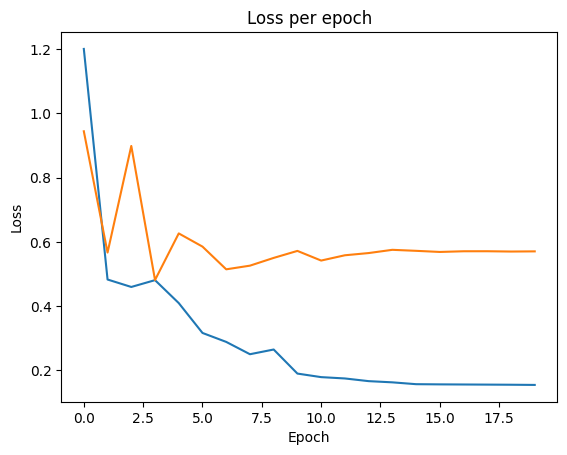

In [61]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss per epoch")
plt.show()

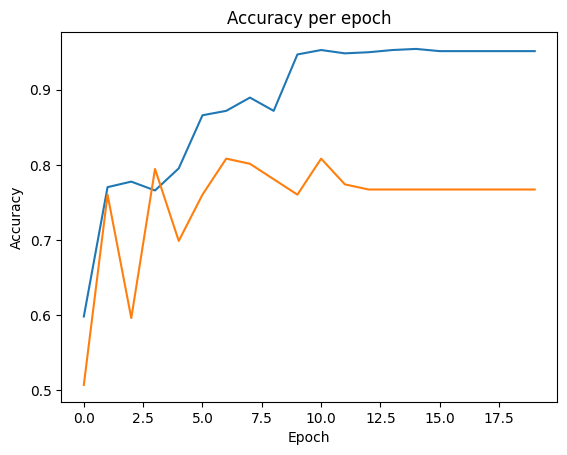

In [62]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy per epoch")
plt.show()